# 9.4 Convolutional Neural Network

## Preparation

In [1]:
# import the needed libraries
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
torch.manual_seed(4)

In [2]:
# Function to plot out the parameters of the Convolutional layers
def plot_channels(W):
    #number of output channels 
    n_out=W.shape[0]
    #number of input channels 
    n_in=W.shape[1]
    w_min=W.min().item()
    w_max=W.max().item()
    fig, axes = plt.subplots(n_out,n_in)
    fig.subplots_adjust(hspace = 0.1)
    out_index=0
    in_index=0
    #plot outputs as rows inputs as columns 
    for ax in axes.flat:
    
        if in_index>n_in-1:
            out_index=out_index+1
            in_index=0
              
        ax.imshow(W[out_index,in_index,:,:], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index=in_index+1

    plt.show()

In [3]:
# Plot data sample 
def show_data(dataset,sample):

    plt.imshow(dataset.x[sample,0,:,:].numpy(),cmap='gray')
    plt.title('y='+str(dataset.y[sample].item()))
    plt.show()

In [4]:
# Import some data
from torch.utils.data import Dataset, DataLoader
class Data(Dataset):
    def __init__(self,N_images=100,offset=0,p=0.9, train=False):
        """
        p:portability that pixel is wight  
        N_images:number of images 
        offset:set a random vertical and horizontal offset images by a sample should be less than 3 
        """
        if train==True:
            np.random.seed(1)  
        
        #make images multiple of 3 
        N_images=2*(N_images//2)
        images=np.zeros((N_images,1,11,11))
        start1=3
        start2=1
        self.y=torch.zeros(N_images).type(torch.long)

        for n in range(N_images):
            if offset>0:
        
                low=int(np.random.randint(low=start1, high=start1+offset, size=1))
                high=int(np.random.randint(low=start2, high=start2+offset, size=1))
            else:
                low=4
                high=1
        
            if n<=N_images//2:
                self.y[n]=0
                images[n,0,high:high+9,low:low+3]= np.random.binomial(1, p, (9,3))
            elif  n>N_images//2:
                self.y[n]=1
                images[n,0,low:low+3,high:high+9] = np.random.binomial(1, p, (3,9))
           
        
        
        self.x=torch.from_numpy(images).type(torch.FloatTensor)
        self.len=self.x.shape[0]
        del(images)
        np.random.seed(0)
    def __getitem__(self,index):      
        return self.x[index],self.y[index]
    def __len__(self):
        return self.len

In [5]:
# plot out the activations of the Convolutional layers
def plot_activations(A,number_rows= 1,name=""):
    A=A[0,:,:,:].detach().numpy()
    n_activations=A.shape[0]
    
    
    print(n_activations)
    A_min=A.min().item()
    A_max=A.max().item()

    if n_activations==1:

        # Plot the image.
        plt.imshow(A[0,:], vmin=A_min, vmax=A_max, cmap='seismic')

    else:
        fig, axes = plt.subplots(number_rows, n_activations//number_rows)
        fig.subplots_adjust(hspace = 0.4)
        for i,ax in enumerate(axes.flat):
            if i< n_activations:
                # Set the label for the sub-plot.
                ax.set_xlabel( "activation:{0}".format(i+1))

                # Plot the image.
                ax.imshow(A[i,:], vmin=A_min, vmax=A_max, cmap='seismic')
                ax.set_xticks([])
                ax.set_yticks([])
    plt.show()

In [6]:
# Utility function for computing output of convolutions takes a tuple of (h,w) and returns a tuple of (h,w)
def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    #by Duane Nielsen
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w

## Prepare Data 

In [8]:
# Load the training dataset with 10000 samples
N_images=10000
train_dataset=Data(N_images=N_images)
validation_dataset=Data(N_images=1000,train=False)
validation_dataset

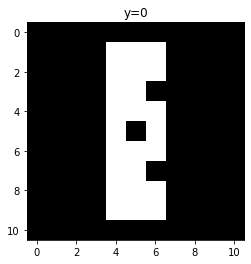

In [9]:
show_data(train_dataset,0)

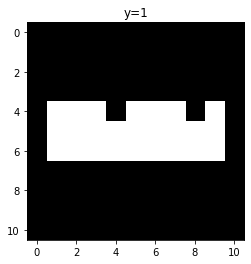

In [10]:
show_data(train_dataset,N_images//2+2)

## Build a Convolutional Neral Network Class

In [11]:
out=conv_output_shape((11,11), kernel_size=2, stride=1, pad=0, dilation=1)
print(out)
out1=conv_output_shape(out, kernel_size=2, stride=1, pad=0, dilation=1)
print(out1)
out2=conv_output_shape(out1, kernel_size=2, stride=1, pad=0, dilation=1)
print(out2)

out3=conv_output_shape(out2, kernel_size=2, stride=1, pad=0, dilation=1)
print(out3)

(10, 10)
(9, 9)
(8, 8)
(7, 7)


Build a Convolutional Network class with two Convolutional layers and one fully connected layer:

In [18]:
class CNN(nn.Module):
    # Construction
    def __init__(self, out_1=1, out_2=1):
        super(CNN,self).__init__()
        # First convolutional Layer
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=2, padding=0)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=1)
        
        # Second convolutional layer
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=2, padding=0)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=1)
        
        # Final connect
        self.fc1 = nn.Linear(out_2*7*7, 2)
    
    # Prediction
    def forward(self, x):
        # First convolutional layer
        x = self.cnn1(x)
        # activation function
        x = torch.relu(x)
        # Maxpool
        x = self.maxpool1(x)
        
        # Second convolutional layer
        x = self.cnn2(x)
        # activation function
        x = torch.relu(x)
        # Maxpool
        x = self.maxpool2(x)
        
        # Flatten output
        x = x.view(x.size(0), -1)
        
        # Fully connected layer
        x = self.fc1(x)
        
        return x
    
    def activations(self,x):
        #outputs activation this is not necessary just for fun 
        z1=self.cnn1(x)
        a1=torch.relu(z1)
        out=self.maxpool1(a1)
        
        z2=self.cnn2(out)
        a2=torch.relu(z2)
        out=self.maxpool2(a2)
        out=out.view(out.size(0),-1)
        return z1,a1,z2,a2,out  

## Define the Convolutional Neral Network Classifier , Criterion function, Optimizer and Train the Model 

In [19]:
# Create a model
model = CNN(2, 1)
model

CNN(
  (cnn1): Conv2d(1, 2, kernel_size=(2, 2), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(2, 1, kernel_size=(2, 2), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=49, out_features=2, bias=True)
)

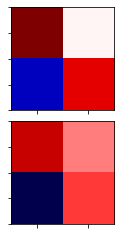

In [20]:
# Plot the model parameters for the kernels before training the kernels
plot_channels(model.state_dict()['cnn1.weight'])

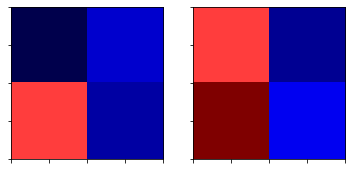

In [21]:
plot_channels(model.state_dict()['cnn2.weight'])

In [27]:
# Create a loss function
critierion = nn.CrossEntropyLoss()

# Create the optimizer function
from torch import optim
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define the trainloader
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=10)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=20)

In [24]:
# Define the training function
def train(model, critierion, train_loader, validation_loader, optimizer, epochs=5):
    
    for epoch in range(n_epochs):
        cost = 0    
        for x, y in train_loader:


            #clear gradient 
            optimizer.zero_grad()
            #make a prediction 
            z=model(x)
            # calculate loss 
            loss=criterion(z,y)
            # calculate gradients of parameters 
            loss.backward()
            # update parameters 
            optimizer.step()
            cost+=loss.item()
        cost_list.append(cost)


        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:

            z=model(x_test)
            _,yhat=torch.max(z.data,1)

            correct+=(yhat==y_test).sum().item()


        accuracy=correct/N_test

        accuracy_list.append(accuracy)

In [28]:
# Set the parameters
n_epochs=10
cost_list=[]
accuracy_list=[]
N_test=len(validation_dataset)
cost=0

In [29]:
# Train the model
train(model, critierion, train_loader, validation_loader, optimizer, epochs=n_epochs)

## Analyse Results

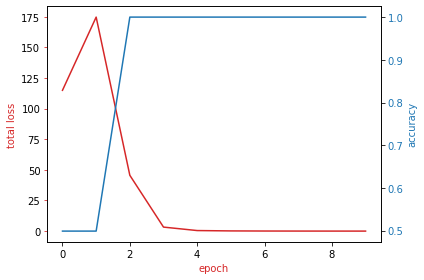

In [30]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

In [31]:
model.state_dict()['cnn1.weight']

tensor([[[[ 0.7465,  0.4736],
          [ 0.0934,  0.4337]]],


        [[[ 0.4917,  0.4203],
          [-0.0743,  0.4025]]]])

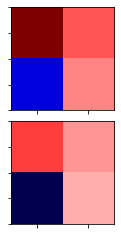

In [32]:
plot_channels(model.state_dict()['cnn1.weight'])

In [33]:
model.state_dict()['cnn1.weight']

tensor([[[[ 0.7465,  0.4736],
          [ 0.0934,  0.4337]]],


        [[[ 0.4917,  0.4203],
          [-0.0743,  0.4025]]]])

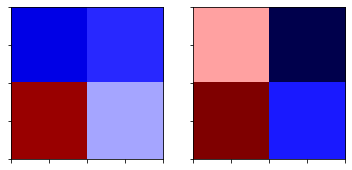

In [34]:
plot_channels(model.state_dict()['cnn2.weight'])

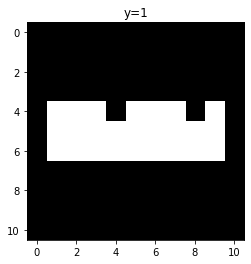

In [35]:
show_data(train_dataset,N_images//2+2)

In [36]:
out=model.activations(train_dataset[N_images//2+2][0].view(1,1,11,11))
out=model.activations(train_dataset[0][0].view(1,1,11,11))

2


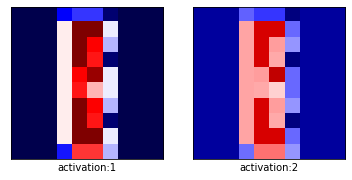

In [37]:
plot_activations(out[0],number_rows=1,name=" feature map")
plt.show()

1


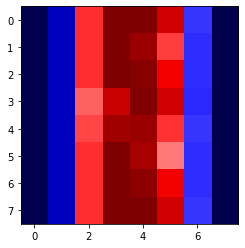

In [38]:
plot_activations(out[2],number_rows=1,name="2nd feature map")
plt.show()

1


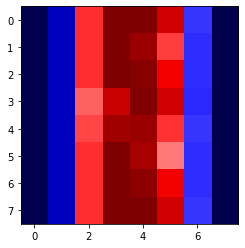

In [39]:
plot_activations(out[3],number_rows=1,name="first feature map")
plt.show()

In [40]:
out1=out[4][0].detach().numpy()

In [41]:
out0=model.activations(train_dataset[100][0].view(1,1,11,11))[4][0].detach().numpy()
out0

array([0.52197677, 2.0373309 , 2.7624183 , 2.9314394 , 2.9314394 ,
       2.487166  , 0.93330264, 0.52197677, 2.109118  , 2.9498873 ,
       2.9498873 , 2.794879  , 2.0935836 , 0.93330264, 0.52197677,
       2.109118  , 2.9498873 , 2.9498873 , 2.8781    , 2.2953782 ,
       0.91108894, 0.52197677, 2.109118  , 2.9498873 , 2.9498873 ,
       2.9498873 , 2.4828472 , 0.9072461 , 0.52197677, 2.109118  ,
       2.9498873 , 2.9498873 , 2.9498873 , 2.4828472 , 0.89570594,
       0.52197677, 2.109118  , 2.9498873 , 2.9498873 , 2.9498873 ,
       2.4828472 , 0.89570594, 0.52197677, 2.109118  , 2.9498873 ,
       2.9498873 , 2.9498873 , 2.4938283 , 0.93330264], dtype=float32)

Text(0, 0.5, 'Activation')

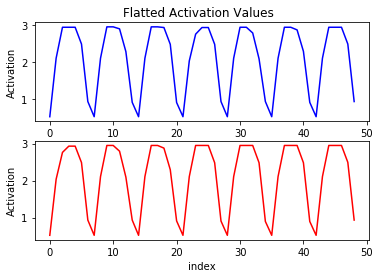

In [42]:
plt.subplot(2, 1, 1)
plt.plot( out1, 'b')
plt.title('Flatted Activation Values  ')
plt.ylabel('Activation')
plt.xlabel('index')
plt.subplot(2, 1, 2)
plt.plot(out0, 'r')
plt.xlabel('index')
plt.ylabel('Activation')